In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import numpy as np
import pandas as pd
import copy

import statsmodels.api as sm

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive/


In [2]:
# Import raw data

data_raw = pd.read_excel('drive/My Drive/Guzman Energy Interview/Assignment 4/Assignment 4 - dataset.xlsx')
data_raw

,Time Series Function,"Contract=ERN,Strip=12/1/2016","Contract=H,Strip=12/1/2016","Contract=XPR,Strip=12/1/2016"
0,NaN,Settlement_Price,Settlement_Price,Settlement_Price
1,NaN,NaN,"""Henry, NG LD1 Futures""",NaN
2,Date (America/Chicago),NaN,NaN,NaN
3,2016-11-28 00:00:00,27.77,3.232,8.592203
4,2016-11-25 00:00:00,26.51,3.085,8.593193
...,...,...,...,...
217,2016-02-01 00:00:00,24.56,2.7,9.096296
218,2016-01-29 00:00:00,24.88,2.742,9.073669
219,2016-01-28 00:00:00,24.43,2.692,9.075037
220,2016-01-27 00:00:00,24.5,2.7,9.074074


In [3]:
# Calculate contract price basing on reference price

data = pd.DataFrame(data_raw.iloc[3:].values.tolist())
data.index = data_raw.index[3:]
data = data.iloc[::-1]
data.columns = ['Time', 'ERN', 'H Refer Price', 'XPR Refer Price']
data.set_index(['Time'], inplace = True)
data['H'] = data['H Refer Price'] * 2500
data['XPR'] = data['XPR Refer Price'] * 50
data = data.drop(['H Refer Price', 'XPR Refer Price'], axis=1)

data

,ERN,H,XPR
Time,,,
2016-01-26,24.62,6782.5,453.741246
2016-01-27,24.50,6750.0,453.703704
2016-01-28,24.43,6730.0,453.751857
2016-01-29,24.88,6855.0,453.683443
2016-02-01,24.56,6750.0,454.814815
...,...,...,...
2016-11-22,26.12,7455.0,437.961100
2016-11-23,26.00,7565.0,429.610046
2016-11-24,26.00,7565.0,429.610046


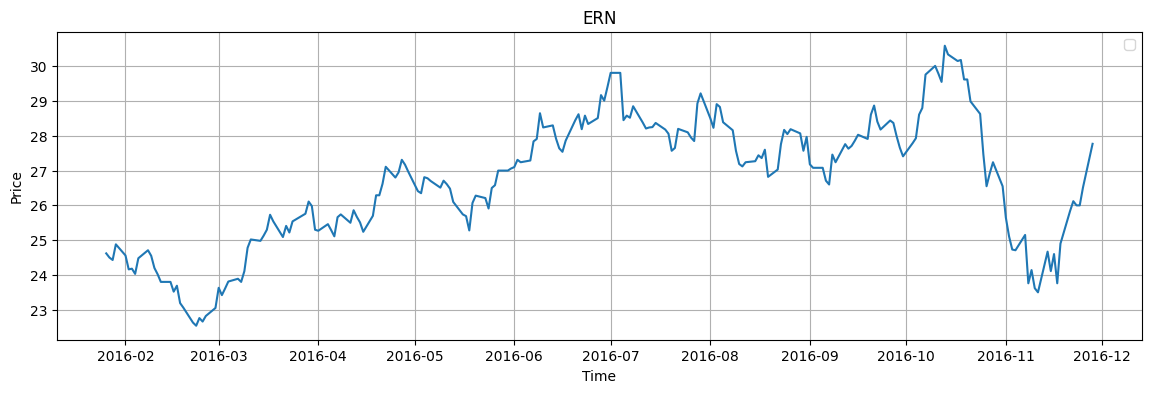

In [4]:
plt.figure(figsize=(14, 4))
plt.plot(data['ERN'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('ERN') 
plt.legend()
plt.grid()

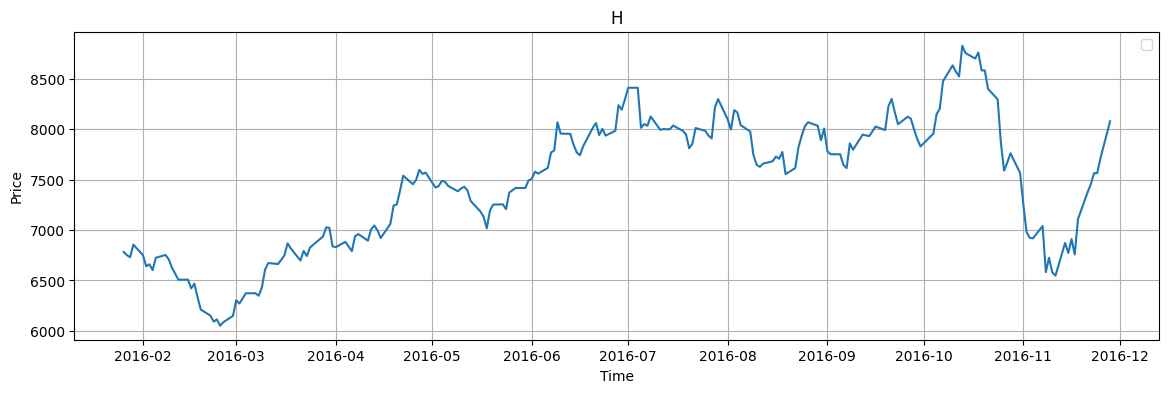

In [5]:
plt.figure(figsize=(14, 4))
plt.plot(data['H'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('H') 
plt.legend()
plt.grid()

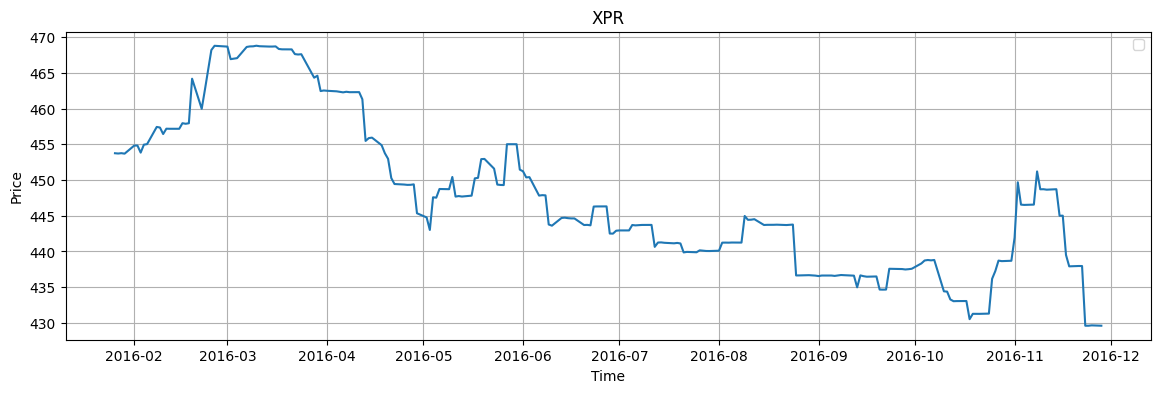

In [6]:
plt.figure(figsize=(14, 4))
plt.plot(data['XPR'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('XPR') 
plt.legend()
plt.grid()

In [7]:
# Calculate correlation
# ERN, H, XPR are highly correlated

data.corr()

,ERN,H,XPR
ERN,1.000000,0.984395,-0.738712
H,0.984395,1.000000,-0.844944
XPR,-0.738712,-0.844944,1.000000


In [8]:
# Build OLS model
# R-squared is 0.999; H and XPR can explain 99.9% of the changes in ERN

y = data['ERN']
x = data[['H', 'XPR']]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ERN   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.535e+05
Date:                Sun, 21 May 2023   Prob (F-statistic):               0.00
Time:                        14:48:02   Log-Likelihood:                 351.23
No. Observations:                 219   AIC:                            -696.5
Df Residuals:                     216   BIC:                            -686.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -25.2234      0.325    -77.620      0.0

In [9]:
# Use OLS coef as position; set XPR position as constant; rebalance H every week

data_weekly = data.resample('1W').mean()
data_weekly['H position'] = np.nan
data_weekly['XPR position'] = np.nan

y = data[data.index < data_weekly.index[9]]['ERN']
x = data[data.index < data_weekly.index[9]][['H', 'XPR']]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
XPR_position = -model.params[2]

for i in range(9, len(data_weekly)): 
  y = data[data.index < data_weekly.index[i]]['ERN'] + data[data.index < data_weekly.index[i]]['XPR'] * XPR_position
  x = data[data.index < data_weekly.index[i]][['H']]
  x = sm.add_constant(x)
  model = sm.OLS(y, x).fit()
  data_weekly['H position'].iloc[i] = -model.params[1]
  data_weekly['XPR position'].iloc[i] = XPR_position

data_weekly['Portfolio'] = data_weekly['ERN'] \
              + data_weekly['H position'].shift(1) * data_weekly['H'] \
              + data_weekly['XPR position'].shift(1) * data_weekly['XPR']

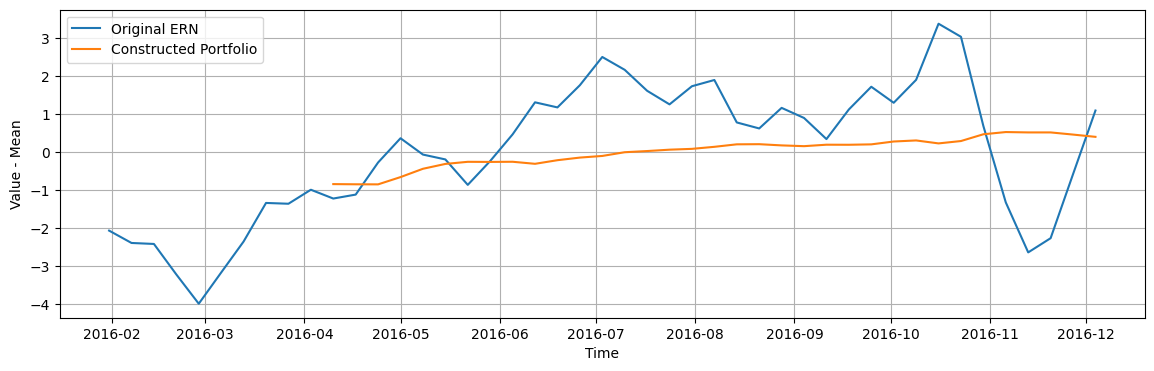

In [10]:
# Compare original ERN with constructed portfolio
# Constructed portfolio is much less volatile

plt.figure(figsize=(14, 4))
plt.xlabel("Time")
plt.ylabel("Value - Mean") 
plt.plot(data_weekly.index, data_weekly['ERN'] - np.mean(data_weekly['ERN']), label = 'Original ERN')
plt.plot(data_weekly.index, data_weekly['Portfolio'] - np.mean(data_weekly['Portfolio']), label = 'Constructed Portfolio')
plt.legend()
plt.grid()

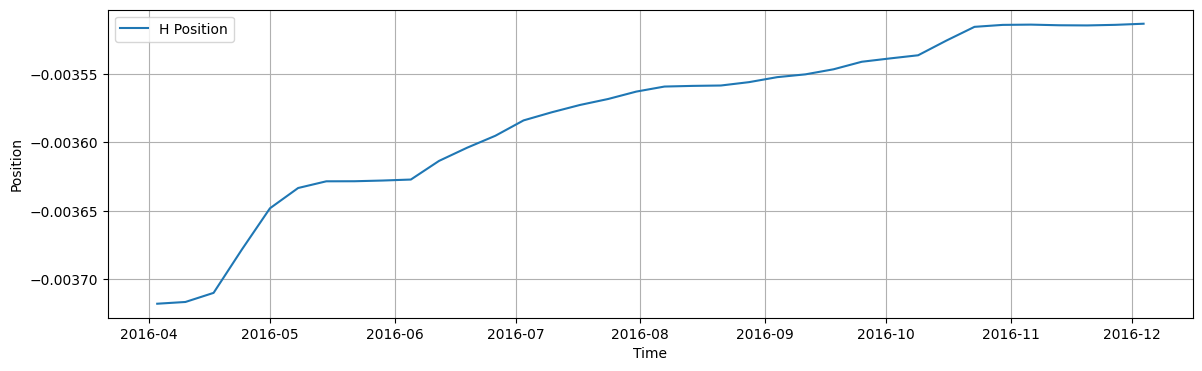

In [11]:
# Position of H

plt.figure(figsize=(14, 4))
plt.xlabel("Time")
plt.ylabel("Position") 
plt.plot(data_weekly.index, data_weekly['H position'], label = 'H Position')
plt.legend()
plt.grid()

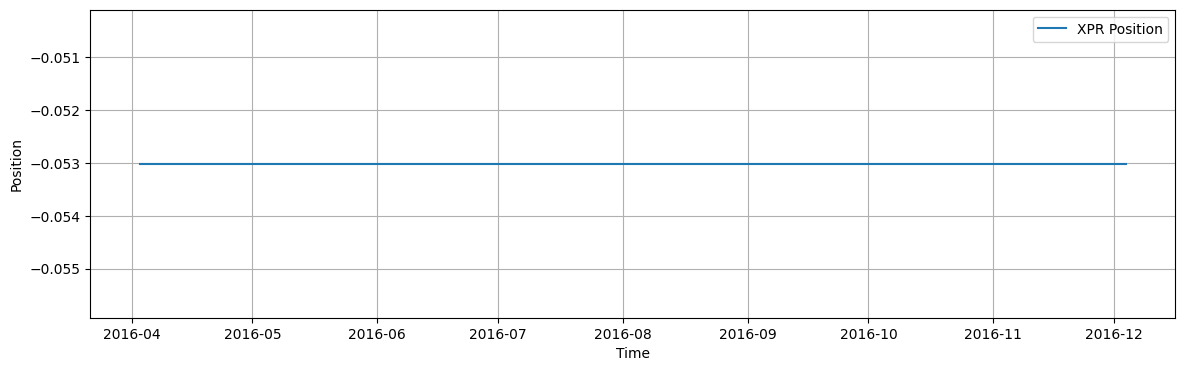

In [12]:
# Position of XPR

plt.figure(figsize=(14, 4))
plt.xlabel("Time")
plt.ylabel("Position") 
plt.plot(data_weekly.index, data_weekly['XPR position'], label = 'XPR Position')
plt.legend()
plt.grid()

In [13]:
# Constructed portfolio is much less volatile than ERN

print('ERN std: ', np.std(data_weekly['ERN'].iloc[10:]))
print('Constructed Portfolio std: ', np.std(data_weekly['Portfolio'].iloc[10:]))

ERN std:  1.368227044054324
Constructed Portfolio std:  0.3873625270170021
